In [90]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from operator import itemgetter
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchbearer import Trial, VALIDATION_DATA, TEST_DATA
from torchbearer.callbacks import ModelCheckpoint

import ipywidgets
from tqdm import tqdm

In [6]:
human_nodes = pd.read_csv("data/BIOSTR_homo_sapiens.nodes", sep=" ")
human_map = dict(zip(human_nodes['nodeSymbol'], np.arange(len(human_nodes))))

In [7]:
### Loading dataset ###
#######################

n_samples = np.loadtxt('data/ML_data/n.txt')
n_pos = np.loadtxt('data/ML_data/n_pos.txt')
n1o_samples = np.loadtxt('data/ML_data/n1o.txt')
n1o_pos = np.loadtxt('data/ML_data/n1o_pos.txt')

if len(n_samples) == len(n1o_samples):
    print("Datasets loaded successfully")
    N = len(n_samples)
else:
    print("Error loading datasets, different sizes")

Datasets loaded successfully


In [119]:
main_proteins_positions = np.sort(np.unique(np.concatenate([n_pos, n1o_pos]))).astype(int)
N_red = len(main_proteins_positions)
map_pos_prot = {i:j for i,j in enumerate(main_proteins_positions)}
map_prot_pos = {j:i for i,j in enumerate(main_proteins_positions)}
n_pos_reduced = np.array([[map_prot_pos[idx] for idx in n_pos[j]] for j in range(len(n_pos))])
n1o_pos_reduced = np.array([[map_prot_pos[idx] for idx in n1o_pos[j]] for j in range(len(n1o_pos))])

In [112]:
def randomize_top_entries_vectors(samples, positions, dim_vec=1000):
    randomized_samples = np.random.rand(samples.shape[0], dim_vec) * 0.1
    for i in range(len(samples)):
        for pos, samp in zip(positions[i], samples[i]):
            samp_scaled = samp 
            randomized_samples[i, pos.astype(int)] = samp
    return randomized_samples

In [120]:
n_randomized = randomize_top_entries_vectors(n_samples, n_pos_reduced, dim_vec=N_red)
n1o_randomized = randomize_top_entries_vectors(n1o_samples, n1o_pos_reduced, dim_vec=N_red)

In [121]:
def normalize_fix_nEntr(Xi, nentr=2000, rng=None, keep_existing_fraction=0.9, in_place=False):
    """
    For each row in Xi, keep the top `nentr` entries (by value). If fewer than `nentr`
    non-zero values exist among those top indices, fill the remaining slots with small
    random positive values. Finally normalize each row to sum to 1.

    Parameters:
    - Xi: array-like, shape (n_samples, n_features)
    - nentr: int, number of entries to keep per row
    - rng: numpy.random.Generator or None (will create default rng if None)
    - keep_existing_fraction: float in (0,1), fraction of mass assigned to existing top values
    - in_place: bool, if True mutate Xi; otherwise operate on a copy and return it

    Returns:
    - Xi_norm: ndarray shape (n_samples, n_features) with rows summing to 1
    """
    Xi_arr = np.asarray(Xi, dtype=float)
    if Xi_arr.ndim != 2:
        raise ValueError("Xi must be 2D (n_samples, n_features)")
    n_samples, n_features = Xi_arr.shape
    if nentr <= 0 or nentr > n_features:
        raise ValueError("nentr must be between 1 and number of features")

    if rng is None:
        rng = np.random.default_rng()

    out = Xi_arr if in_place else Xi_arr.copy()

    for i in tqdm(range(n_samples)):
        row = out[i]
        # make non-negative (if negative values are possible), keep original sign if desired change here
        row = np.maximum(row, 0.0)

        # efficient selection of top-n indices
        top_idx = np.argpartition(row, -nentr)[-nentr:]
        top_vals = row[top_idx]

        kept = np.zeros(n_features, dtype=float)
        kept[top_idx] = top_vals

        n_nz = np.count_nonzero(kept)
        if n_nz == nentr:
            s = kept.sum()
            # avoid division by zero; if s==0 then distribute uniformly across top_idx
            if s == 0:
                kept[top_idx] = 1.0 / nentr
            else:
                kept /= s
            out[i] = kept
            continue

        # need to fill m slots with random positive values
        m = nentr - n_nz
        zero_positions = np.where(kept == 0)[0]
        chosen = rng.choice(zero_positions, size=m, replace=False)

        existing_sum = kept.sum()
        if existing_sum > 0:
            # scale existing mass to keep_existing_fraction
            kept = (kept / existing_sum) * keep_existing_fraction
            rand_vals = rng.random(m)
            rand_vals = rand_vals / rand_vals.sum() * (1.0 - keep_existing_fraction)
            kept[chosen] = rand_vals
        else:
            # no existing mass among top entries -> distribute full mass to random picks
            rand_vals = rng.random(m)
            rand_vals = rand_vals / rand_vals.sum()
            kept[chosen] = rand_vals

        # final normalization to ensure numerical precision
        s = kept.sum()
        if s == 0:
            # fallback to uniform over top_idx
            kept[top_idx] = 1.0 / nentr
        else:
            kept /= s

        out[i] = kept

    return out

In [125]:
# Training samples
print("Loading Train and Val")
X = np.concatenate([n_randomized, n1o_randomized], axis=0)

# Assigning label, 0 for only non-oncogenic layers, 1 for oncogenic layer presence
y = np.concatenate([[0]*N, [1]*N])

print(X.shape, y.shape)

Loading Train and Val
(200, 1175) (200,)


In [126]:
class OncoVirusDataset(Dataset):
    """OncoVirus Dataset"""
    
    def __init__(self, X, y=None, test=False):
        """
        Args:
        """
        self.test = test
        self.data = X
        self.labels = y
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dat = self.data[idx]#np.array([self.data[idx].nonzero()[0], self.data[idx][self.data[idx].nonzero()[0]]])
        if self.test:
            return torch.from_numpy(dat).type(torch.FloatTensor)
        else:
            return [torch.from_numpy(dat).type(torch.FloatTensor), int(self.labels[idx])]
        

In [127]:
class Model(nn.Module):
    def __init__(self, input_dim=19945):
        super().__init__()
        self.linear = nn.Linear(in_features=input_dim, out_features=2)

    def forward(self, x):
        x=self.linear(x)
        return x

model = Model()

In [128]:
def set_up_trial(X, y, val_size=0.2, test_size=0.2, n_epochs=600, model_input_dim=19945):
    index_rem = np.random.choice(len(X), size=int(len(X)*test_size), replace=False)
    X_test = X[index_rem]
    y_test = y[index_rem]
    X_train, X_val, y_train, y_val = train_test_split(X[np.delete(np.arange(len(X)), index_rem)], y[np.delete(np.arange(len(X)), index_rem)], test_size=val_size, random_state=42)

    mydat_train = OncoVirusDataset(X_train, y_train)
    mydat_val = OncoVirusDataset(X_val, y_val)
    mydat_test = OncoVirusDataset(X_test, y_test)

    train_dataloader = DataLoader(mydat_train, batch_size=20, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(mydat_val, batch_size=20, shuffle=False, num_workers=0)
    test_dataloader = DataLoader(mydat_test, batch_size=20, shuffle=False, num_workers=0)

    model = Model(input_dim=model_input_dim)
    
    trial = Trial(model,
                  optim.Adam(model.parameters(), lr=1e-3),
                  nn.CrossEntropyLoss(), 
                  metrics=["loss", "acc"])
    
    trial.with_generators(train_generator=train_dataloader, 
                              val_generator=val_dataloader, 
                              test_generator=test_dataloader)

    my_trial = trial.run(epochs=n_epochs, verbose=1)

    return trial, my_trial

In [129]:
trial, mytrial = set_up_trial(X, y, val_size=0.2, test_size=0.1, n_epochs=600, model_input_dim=N_red)

  0%|          | 0/600 [00:00<?, ?it/s]

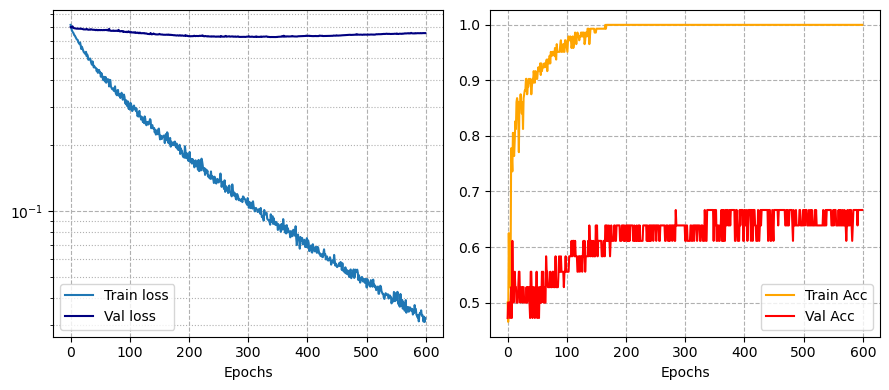

In [130]:
__, ax = plt.subplots(1,2,figsize=(9,4))

ax[0].semilogy([mt["loss"] for mt in mytrial], label="Train loss", color="C0")
ax[0].semilogy([mt["val_loss"] for mt in mytrial], label="Val loss", color="navy")

ax[1].plot([mt["acc"] for mt in mytrial], label="Train Acc", color="orange")
ax[1].plot([mt["val_acc"] for mt in mytrial], label="Val Acc", color="red")

[axi.set_xlabel("Epochs") for axi in ax]
[axi.legend() for axi in ax]
[axi.grid(ls="--") for axi in ax]
ax[0].grid(which="minor", ls=":")
plt.tight_layout()

In [131]:
def plot_confusion_matrix(trial, which="val"):
    if which=="val":
        val_pred=np.argmax(trial.predict(data_key=VALIDATION_DATA).detach().numpy(),axis=1)
        val_true=[v[1] for v in trial.state.data["validation_generator"].dataset]
        title="VALIDATION CONFUSION MATRIX"
    elif which=="test":
        val_pred=np.argmax(trial.predict(data_key=TEST_DATA).detach().numpy(),axis=1)
        val_true=[v[1] for v in trial.state.data["test_generator"].dataset]
        title="TEST CONFUSION MATRIX"
    else:
        raise ValueError("which should be either val or test")
    
    confM_val = confusion_matrix(y_true = val_true, y_pred = val_pred, labels=np.arange(2))

    plt.figure(figsize=(6,6))
    sns.heatmap(confM_val, annot=True, fmt="g", cbar=False, cmap="magma")
    plt.title(title, weight="bold")
    plt.ylabel("True labels")
    plt.xlabel("Predicted labels")
    plt.tight_layout()
    
    return confM_val

0/1(p):   0%|          | 0/2 [00:00<?, ?it/s]

/home/francesco/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: State was accessed with a string: validation_generator, generate keys with StateKey(str).
  after removing the cwd from sys.path.


array([[11,  7],
       [ 5, 13]])

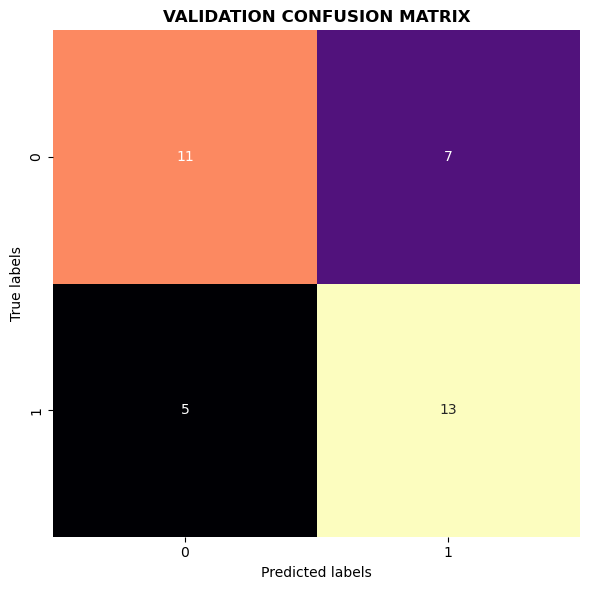

In [133]:
plot_confusion_matrix(trial, which="val")

/home/francesco/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: State was accessed with a string: model, generate keys with StateKey(str).
  


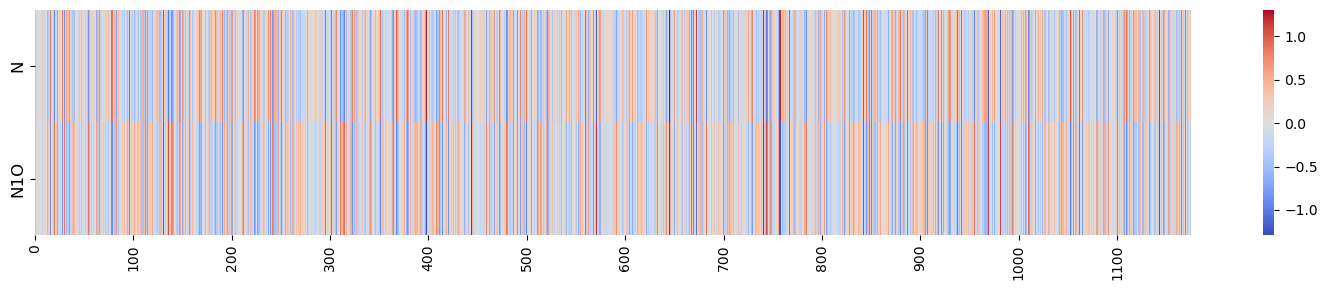

In [155]:
plt.figure(figsize=(15,3))
weights = trial.state['model'].linear.weight.detach().numpy()
sns.heatmap(weights, cmap="coolwarm", yticklabels=["N","N1O"])
plt.yticks(fontsize=12)
plt.xticks(ticks=np.arange(0,N_red,100), labels=np.arange(0,N_red,100))
plt.tight_layout()
plt.show()

<AxesSubplot:>

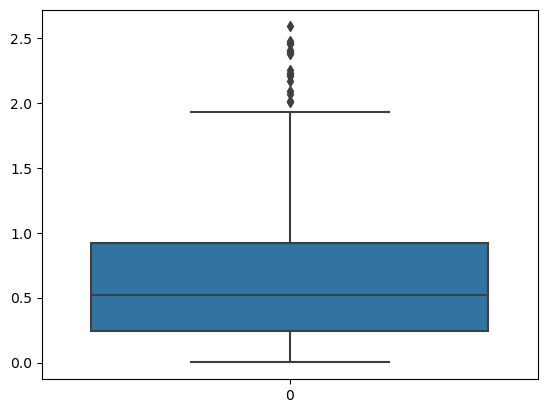

In [159]:
sns.boxplot(np.abs(weights[0]-weights[1]))